In [1]:
# !yes | conda install pytorch torchvision -c pytorch
# !yes | conda install numpy
# !yes | conda install tqdm
# !yes | conda install matplotlib

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.nn import init
from argparse import Namespace
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import functional as FT

In [4]:
!nvidia-smi

Thu Dec 27 19:27:46 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0  On |                  N/A |
| 42%   66C    P2   182W / 250W |   8805MiB / 11172MiB |     97%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0A:00.0  On |                  N/A |
| 45%   66C    P8    21W / 250W |     22MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
args = Namespace(
    n_batch=128,
    device='cuda:3'
)

In [6]:
train = CIFAR10(
    '.', 
    transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]), 
    download=True
)
train_dl = DataLoader(train, args.n_batch, shuffle=True, num_workers=4, drop_last=True)

Files already downloaded and verified


In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(8 * 8 * 16, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """[B x 3 x 32 x 32] => [B x 512]"""
        
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 8 * 8 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        
        return fc1

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc3 = nn.Linear(128, 512)
        self.fc_bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 8 * 8 * 16)
        self.fc_bn4 = nn.BatchNorm1d(8 * 8 * 16)

        self.conv5 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()
    
    def forward(self, z):
        """[B x 512] => [B x 3 x 32 x 32]"""

        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 8, 8)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        
        return torch.sigmoid(self.conv8(conv7).view(-1, 3, 32, 32))

In [9]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.enc_mu = nn.Linear(512, 128)
        self.enc_logvar = nn.Linear(512, 128)

    def forward(self, x):
        h = self.encoder(x)
        
        mu, logvar = self.enc_mu(h), self.enc_logvar(h)
        sigma = (logvar * 0.5).exp_()
        z = mu + sigma * torch.randn_like(sigma)
        
        xh = self.decoder(z)
        
        return (mu, logvar), xh
    
    def sample(self, n=1):
        z = torch.randn(n, 128, 
                        dtype=torch.float, 
                        device=self.enc_mu.weight.device)
        
        xh = self.decoder(z)
        xh = xh.detach()
        
        return xh

In [10]:
def weights_init(m):
    if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, (nn.Conv2d, nn.Conv3d,
                        nn.ConvTranspose2d, nn.ConvTranspose3d)):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        init.normal_(m.weight.data, mean=1, std=0.025)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)


def latent_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [11]:
device = torch.device(args.device)
model = VAE(Encoder(), Decoder()).to(device)
# model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in tqdm.tqdm_notebook(range(150)):
    total_loss = 0
    for x, _ in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        h, xh = model(x)
        loss = F.mse_loss(xh, x, reduction='sum') + latent_loss(*h)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    total_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss}')

i_epoch=0 loss=14421.23819110577


i_epoch=1 loss=11844.858325821315


i_epoch=2 loss=10999.407344250802


i_epoch=3 loss=10596.352969751602


i_epoch=4 loss=10381.566646634616


i_epoch=5 loss=10256.058573717948


i_epoch=6 loss=10166.134182191507


i_epoch=7 loss=10099.203182592148


i_epoch=8 loss=10057.28284004407


i_epoch=9 loss=10029.487802984775


i_epoch=10 loss=9975.341321113781


i_epoch=11 loss=9950.00217598157


i_epoch=12 loss=9927.761646133815


i_epoch=13 loss=9918.74423828125


i_epoch=14 loss=9888.948079427084


i_epoch=15 loss=9873.785028545673


i_epoch=16 loss=9855.76744541266


i_epoch=17 loss=9844.499934895834


i_epoch=18 loss=9837.530841846956


i_epoch=19 loss=9821.69061748798


i_epoch=20 loss=9816.081630608975


i_epoch=21 loss=9773.767568108975


i_epoch=22 loss=9777.11055438702


i_epoch=23 loss=9766.983087940705


i_epoch=24 loss=9744.712830528846


i_epoch=25 loss=9728.559763120993


i_epoch=26 loss=9714.932922676282


i_epoch=27 loss=9706.583057892629


i_epoch=28 loss=9691.98108223157


i_epoch=29 loss=9676.686255508814


i_epoch=30 loss=9674.543642327724


i_epoch=31 loss=9672.618622295673


i_epoch=32 loss=9655.219971955128


i_epoch=33 loss=9645.921977664262


i_epoch=34 loss=9647.309322415866


i_epoch=35 loss=9635.485737179488


i_epoch=36 loss=9643.05117938702


i_epoch=37 loss=9621.629114082532


i_epoch=38 loss=9612.326129306892


i_epoch=39 loss=9617.418166566506


i_epoch=40 loss=9610.27373798077


i_epoch=41 loss=9602.23755508814


i_epoch=42 loss=9599.39723808093


i_epoch=43 loss=9594.682489483173


i_epoch=44 loss=9584.277736879007


i_epoch=45 loss=9584.852509014423


i_epoch=46 loss=9571.060724659455


i_epoch=47 loss=9566.65075370593


i_epoch=48 loss=9560.008260717148


i_epoch=49 loss=9565.23739483173


i_epoch=50 loss=9550.889225260416


i_epoch=51 loss=9560.22975761218


i_epoch=52 loss=9558.765655048077


i_epoch=53 loss=9552.7213666867


i_epoch=54 loss=9553.944448617789


i_epoch=55 loss=9550.30250400641


i_epoch=56 loss=9538.062014222756


i_epoch=57 loss=9539.638474058494


i_epoch=58 loss=9535.408738982373


i_epoch=59 loss=9539.08486328125


i_epoch=60 loss=9523.575595953525


i_epoch=61 loss=9536.294689002403


i_epoch=62 loss=9524.469839242789


i_epoch=63 loss=9513.032502003205


i_epoch=64 loss=9521.12855819311


i_epoch=65 loss=9510.495477764423


i_epoch=66 loss=9509.371727263622


i_epoch=67 loss=9506.652669270834


i_epoch=68 loss=9503.096832431891


i_epoch=69 loss=9498.239938902243


i_epoch=70 loss=9502.71315604968


i_epoch=71 loss=9502.283571213942


i_epoch=72 loss=9500.998600260416


i_epoch=73 loss=9487.397989282852


i_epoch=74 loss=9485.757076322116


i_epoch=75 loss=9486.147768930288


i_epoch=76 loss=9476.514075020032


i_epoch=77 loss=9473.819178185096


i_epoch=78 loss=9468.566055689103


i_epoch=79 loss=9483.856330128205


i_epoch=80 loss=9481.879407051281


i_epoch=81 loss=9478.14169170673


i_epoch=82 loss=9471.377160957532


i_epoch=83 loss=9464.613899739583


i_epoch=84 loss=9470.553322816506


i_epoch=85 loss=9460.303916266026


i_epoch=86 loss=9465.809560296475


i_epoch=87 loss=9461.20592948718


i_epoch=88 loss=9448.703049879809


i_epoch=89 loss=9452.546529447116


i_epoch=90 loss=9448.399033453526


i_epoch=91 loss=9448.261250500802


i_epoch=92 loss=9446.495495292467


i_epoch=93 loss=9443.522200520832


i_epoch=94 loss=9446.4950395633


i_epoch=95 loss=9445.651502403845


i_epoch=96 loss=9438.816611578526


i_epoch=97 loss=9431.172658754007


i_epoch=98 loss=9434.374256310097


i_epoch=99 loss=9436.084805689103


i_epoch=100 loss=9438.885589443109


i_epoch=101 loss=9420.780764222756


i_epoch=102 loss=9435.018892728365


i_epoch=103 loss=9434.676770332531


i_epoch=104 loss=9429.544533754006


i_epoch=105 loss=9420.729639923878


i_epoch=106 loss=9425.243111478365


i_epoch=107 loss=9422.932384314903


i_epoch=108 loss=9420.685789763622


i_epoch=109 loss=9421.999634415064


i_epoch=110 loss=9416.064923878204


i_epoch=111 loss=9412.689836237982


i_epoch=112 loss=9414.599659455129


i_epoch=113 loss=9420.206322616186


i_epoch=114 loss=9409.74609375


i_epoch=115 loss=9411.705962039263


i_epoch=116 loss=9410.170690604968


i_epoch=117 loss=9410.489998998397


i_epoch=118 loss=9406.47828525641


i_epoch=119 loss=9397.589342948719


i_epoch=120 loss=9399.148116987179


i_epoch=121 loss=9398.552045773236


i_epoch=122 loss=9402.632762419871


i_epoch=123 loss=9398.037983273238


i_epoch=124 loss=9391.72808994391


i_epoch=125 loss=9399.77291416266


i_epoch=126 loss=9391.476938100961


i_epoch=127 loss=9398.011443309295


i_epoch=128 loss=9399.31467598157


i_epoch=129 loss=9394.172748898238


i_epoch=130 loss=9398.4059369992


i_epoch=131 loss=9393.94854266827


i_epoch=132 loss=9390.764400540866


i_epoch=133 loss=9387.376930588942


i_epoch=134 loss=9386.808213141026


i_epoch=135 loss=9385.788489082532


i_epoch=136 loss=9397.970325020033


i_epoch=137 loss=9387.024516726762


i_epoch=138 loss=9378.981402744392


i_epoch=139 loss=9380.281237479969


i_epoch=140 loss=9378.649356470352


i_epoch=141 loss=9384.15780498798


i_epoch=142 loss=9380.296389222756


i_epoch=143 loss=9370.854532251602


i_epoch=144 loss=9379.223147035256


i_epoch=145 loss=9377.861651141828


i_epoch=146 loss=9376.643892728365


i_epoch=147 loss=9362.064307892628


i_epoch=148 loss=9366.042856069711


i_epoch=149 loss=9366.35647285657



In [17]:
model.eval();

In [18]:
def t2np(image):
    image = np.array(image.getdata(), np.uint8).reshape(image.size[1], image.size[0], 3)
    return image


def sample():
    image = FT.to_pil_image(model.sample()[0].cpu())
    image = t2np(image)
    plt.imshow(image);

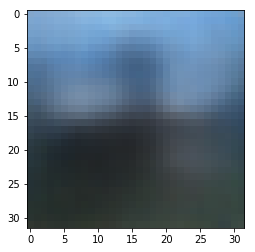

In [19]:
sample()

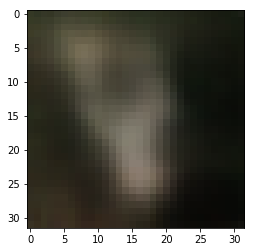

In [20]:
sample()

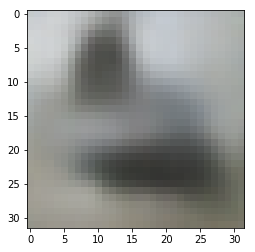

In [22]:
sample()